In [1]:
import pandas as pd
import numpy as np
from pandas import Series

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')

In [3]:
display(train)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,0
73795,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,0
73796,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,0
73797,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1


client_id - идентификатор клиента, education - уровень образования, sex - пол заемщика, age - возраст заемщика, car - флаг наличия автомобиля, car_type - флаг автомобиля иномарки, decline_app_cnt - количество отказанных прошлых заявок, good_work - флаг наличия “хорошей” работы, bki_request_cnt - количество запросов в БКИ, home_address - категоризатор домашнего адреса, work_address - категоризатор рабочего адреса, income - доход заемщика, foreign_passport - наличие загранпаспорта, sna - связь заемщика с клиентами банка, first_time - давность наличия информации о заемщике, score_bki - скоринговый балл по данным из БКИ, region_rating - рейтинг региона, app_date - дата подачи заявки, default - флаг дефолта по кредиту

In [4]:
train.app_date = train.app_date.apply(lambda x: datetime.strptime(x, '%d%b%Y'))

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   client_id         73799 non-null  int64         
 1   app_date          73799 non-null  datetime64[ns]
 2   education         73492 non-null  object        
 3   sex               73799 non-null  object        
 4   age               73799 non-null  int64         
 5   car               73799 non-null  object        
 6   car_type          73799 non-null  object        
 7   decline_app_cnt   73799 non-null  int64         
 8   good_work         73799 non-null  int64         
 9   score_bki         73799 non-null  float64       
 10  bki_request_cnt   73799 non-null  int64         
 11  region_rating     73799 non-null  int64         
 12  home_address      73799 non-null  int64         
 13  work_address      73799 non-null  int64         
 14  income            7379

In [6]:
train = train.dropna()

In [7]:
cols_list = train.columns.tolist()
for value in cols_list:
    print(value,':', train[value].value_counts().count())

client_id : 73492
app_date : 120
education : 5
sex : 2
age : 52
car : 2
car_type : 2
decline_app_cnt : 21
good_work : 2
score_bki : 68808
bki_request_cnt : 38
region_rating : 7
home_address : 3
work_address : 3
income : 965
sna : 4
first_time : 4
foreign_passport : 2
default : 2


In [8]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# cat_cols = train.select_dtypes(exclude=[np.number])
# cat_cols_list = list(set(cat_cols.columns.tolist()) - set(bin_cols))
# num_cols = train.select_dtypes(include=[np.number])
# num_cols_list = list(set(num_cols.columns.tolist()) - set(bin_cols))
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'first_time', 'sna']
num_cols = ['income', 'decline_app_cnt', 'score_bki', 'age', 'bki_request_cnt']
print(bin_cols)
print(cat_cols)
print(num_cols)

['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
['education', 'region_rating', 'home_address', 'work_address', 'first_time', 'sna']
['income', 'decline_app_cnt', 'score_bki', 'age', 'bki_request_cnt']


In [9]:
def histogram(df):
    sns.set()
    f, axes = plt.subplots(figsize=(15, 5))
    sns.distplot(df, kde = False, rug=False)
    
def boxplot(x_data, y_data, data):
    sns.set(style="ticks", palette="pastel")
    f, axes = plt.subplots()
    sns.boxplot(x=x_data, y=y_data, palette=['m', 'g'], data = data)
    sns.despine(offset=10, trim=True)
    
def countplot(x_data, df):
    f, ax = plt.subplots()
    ax = sns.countplot(x=x_data, data=df)

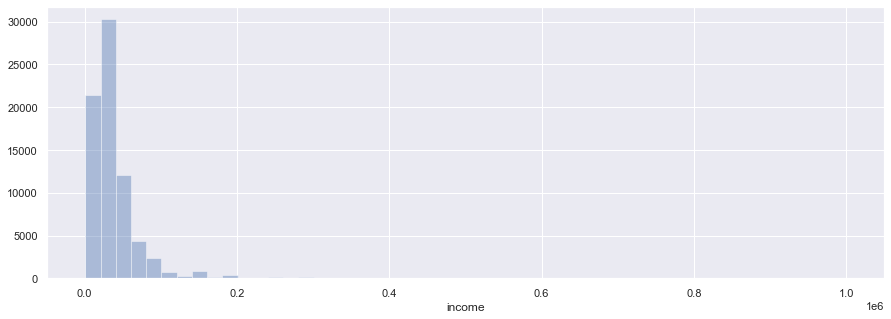

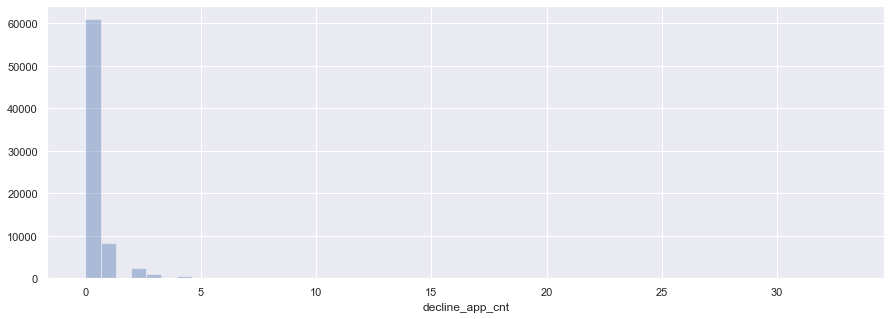

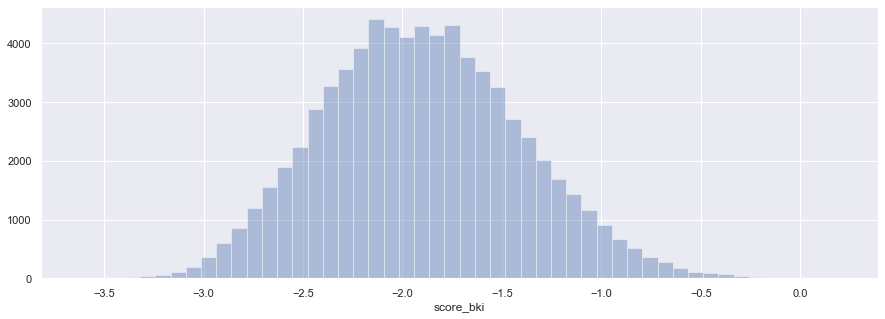

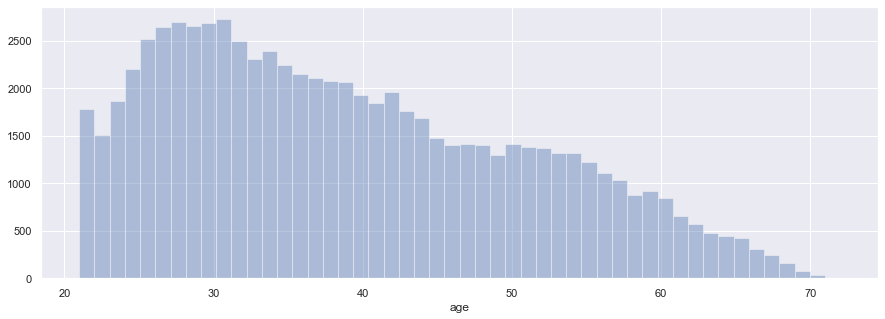

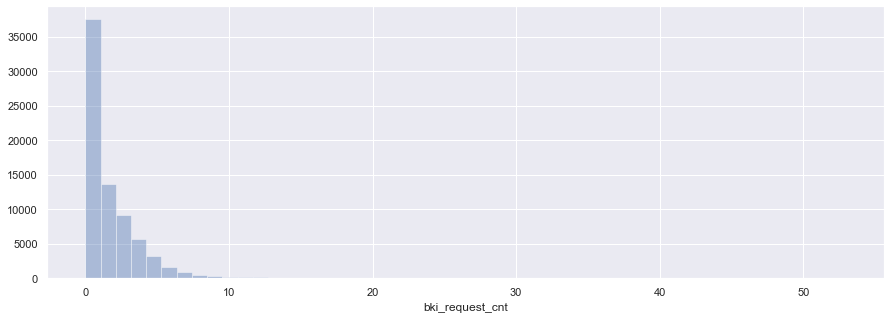

In [10]:
for value in num_cols:
    histogram(train[value])

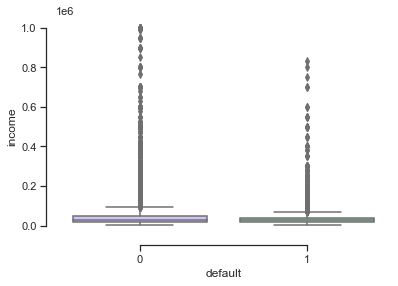

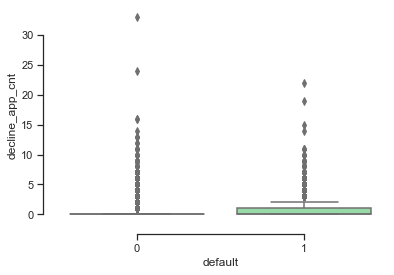

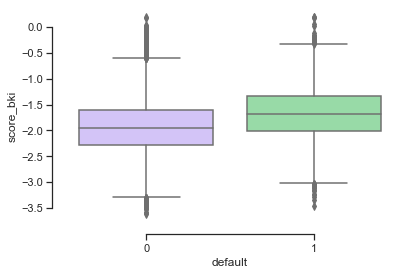

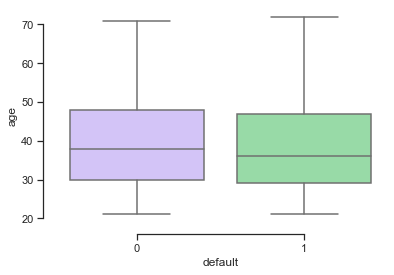

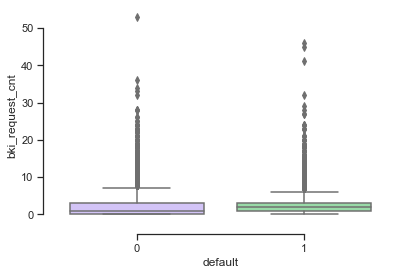

In [11]:
for value in num_cols:
    boxplot(train['default'], train[value], train)

In [12]:
train.region_rating = train.region_rating/10

In [13]:
train.income = round(train.income/1000)

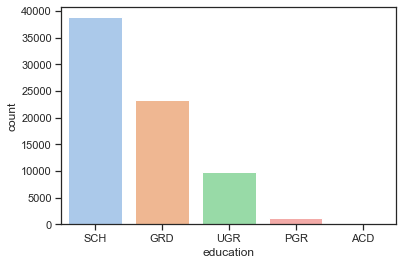

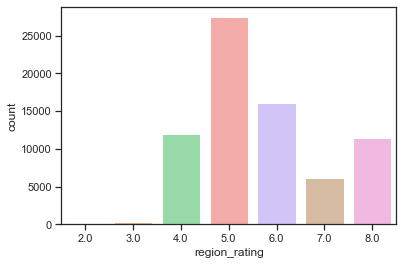

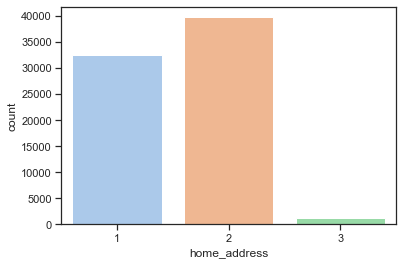

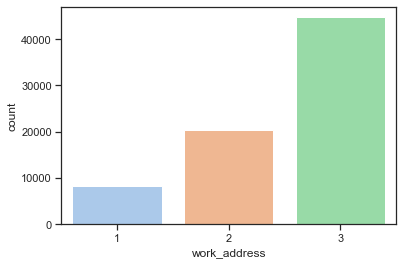

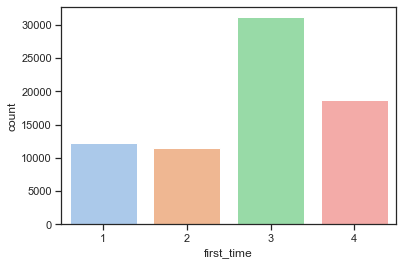

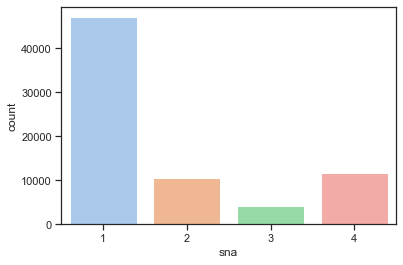

In [14]:
for value in cat_cols:
    countplot(value, train)

<AxesSubplot:>

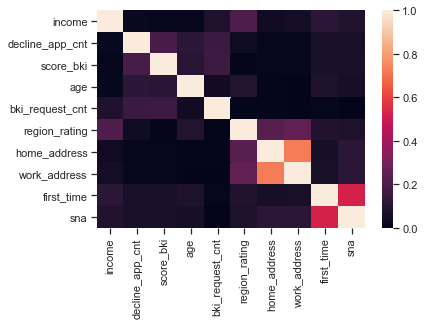

In [15]:
sns.heatmap(train[num_cols + cat_cols].corr().abs(), vmin=0, vmax=1)

work_address сильно коррелирует с home_address, поэтому можно удалить один из них (work_address, т.к. он менее значимый). Остальные коррелируют слабо, кроме sna и first_time, значение которых мне несовсем понятно. sna точно оставляем, поэкспериментируем в дальнейшем с удалением first_time.

### Значимость непрерывных переменных 

<AxesSubplot:>

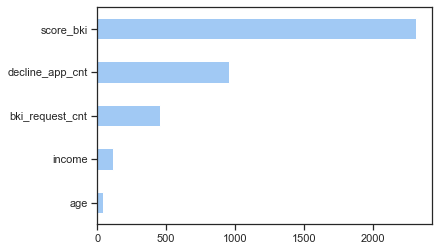

In [16]:
imp_num = Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

### Категориальные переменные

In [17]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(train['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


In [18]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    
# убедимся в преобразовании    
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,2014-02-01,SCH,1,62,1,1,0,0,-2.008753,1,5.0,1,2,18.0,4,1,0,0
1,63161,2014-03-12,SCH,0,59,0,0,0,0,-1.532276,3,5.0,2,3,19.0,4,1,0,0
2,25887,2014-02-01,SCH,1,25,1,0,2,0,-1.408142,1,8.0,1,2,30.0,1,4,1,0
3,16222,2014-01-23,SCH,0,53,0,0,0,0,-2.057471,2,5.0,2,3,10.0,1,3,0,0
4,101655,2014-04-18,GRD,1,48,0,0,0,1,-1.244723,1,6.0,2,3,30.0,1,4,1,0


In [19]:
# Замена строковых категориальных переменных на числовые
dct_edu = {'SCH': 0, 'GRD': 1, 'UGR': 2, 'PGR': 3, 'ACD': 4}
train['education'] = train['education'].map(dct_edu)
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,2014-02-01,0,1,62,1,1,0,0,-2.008753,1,5.0,1,2,18.0,4,1,0,0
1,63161,2014-03-12,0,0,59,0,0,0,0,-1.532276,3,5.0,2,3,19.0,4,1,0,0
2,25887,2014-02-01,0,1,25,1,0,2,0,-1.408142,1,8.0,1,2,30.0,1,4,1,0
3,16222,2014-01-23,0,0,53,0,0,0,0,-2.057471,2,5.0,2,3,10.0,1,3,0,0
4,101655,2014-04-18,1,1,48,0,0,0,1,-1.244723,1,6.0,2,3,30.0,1,4,1,0


<AxesSubplot:>

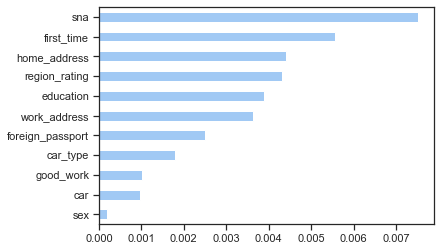

In [20]:
# Значимость бинарных переменных
imp_cat = Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'], 
                                     discrete_features = True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [21]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train[bin_cols + cat_cols].values)
# new_features = pd.DataFrame(X_cat, columns=['sex_f', 'sex_m', 'car_n', 'car_y', 'car_type_n', 'car_type_y', 'good_work_n',
#                                            'good_work_y', 'foreign_passport_n', 'foreign_passport_y', 'edu_0', 'edu_1', 
#                                            'edu_2', 'edu_3', 'edu_4', 'reg_rat_0', 'reg_rat_1', 'reg_rat_2', 'reg_rat_3',
#                                           'reg_rat_4', 'reg_rat_5', 'reg_rat_6', 'home_add_0', 'home_add_1', 'home_add_2', 
#                                            'work_add_0', 'work_add_1', 'work_add_2', 'first_time_0', 'first_time_1', 
#                                            'first_time_2', 'first_time_3', 'sna_0', 'sna_1', 'sna_2', 'sna_3'])
# train = train.merge(new_features, left_index=True, right_index=True, how='right')
# train.head()

In [22]:
X_num = StandardScaler().fit_transform(train[num_cols].values)

In [23]:
X_tr = np.hstack([X_num, X_cat])
Y_tr = train['default'].values

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_tr, Y_tr, test_size=0.30, random_state=42)

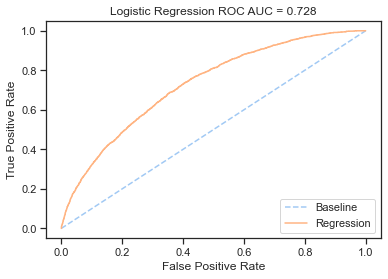

In [25]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_val)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_val, probs)
roc_auc = roc_auc_score(y_val, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Подготовка тестового датафрейма

In [26]:
test = pd.read_csv('test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [27]:
test['education'].fillna('SCH', inplace=True)

In [28]:
test.app_date = test.app_date.apply(lambda x: datetime.strptime(x, '%d%b%Y'))
test.region_rating = test.region_rating/10
test.income = round(test.income/1000)
test['education'] = test['education'].map(dct_edu)
X_cat_test = OneHotEncoder(sparse = False).fit_transform(test[bin_cols + cat_cols].values)
X_num_test = StandardScaler().fit_transform(test[num_cols].values)
X_test = np.hstack([X_num_test, X_cat_test])

In [29]:
model = LogisticRegression()
model.fit(X_tr, Y_tr)

LogisticRegression()

In [30]:
# Добавить фиктивный столбец единиц (bias линейной модели)
X_bias = np.hstack([np.ones(X_tr.shape[0])[:, np.newaxis], X_tr])
m = X_tr.shape[1]

In [31]:
# Реализовать функцию sigmoid
def sigmoid(X, theta):
    return 1. / (1. + np.exp(-X.dot(theta)))

# Реализовать функцию, вычисляющую градиент бинарной кросс-энтропии
def calc_binary_cross_entropy_grad(X, y, theta):
    n = X.shape[0]
    grad = 1. / n * X.transpose().dot(sigmoid(X, theta) - y)
    
    return grad

def gradient_step(theta, theta_grad, alpha):
    return theta - alpha * theta_grad

def optimize(X, y, grad_func, start_theta, alpha, n_iters):
    theta = start_theta.copy()
    
    for i in range(n_iters):
        theta_grad = grad_func(X, y, theta)
        theta = gradient_step(theta, theta_grad, alpha)
    
    return theta

def calc_and_plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)
    

In [32]:
# Оптимизировать параметр линейной регрессии theta на всех данных
theta = optimize(X_tr, Y_tr, calc_binary_cross_entropy_grad, np.ones(m), 1., 300)

In [33]:
# Сделать предсказания на тренировочной выборке
y_pred = sigmoid(X_test, theta)
print(y_pred)

[0.03800785 0.31010799 0.0666291  ... 0.32909749 0.13862552 0.25775399]


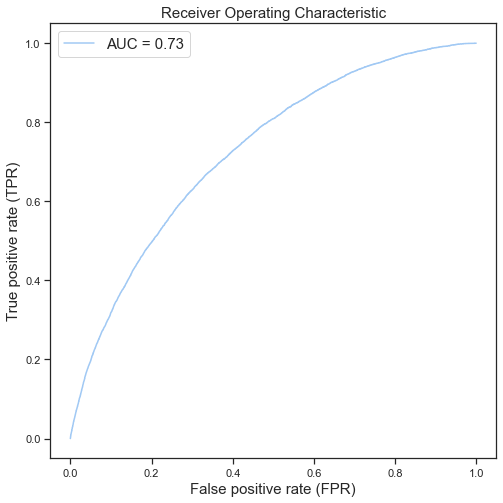

In [34]:
y_pred_proba = sigmoid(X_tr, theta)
calc_and_plot_roc(Y_tr, y_pred_proba)

In [35]:
data = pd.DataFrame(data=test.client_id, columns=['client_id'], dtype=str)
Y_test = pd.DataFrame(data=y_pred, columns=['default'])
data = data.merge(Y_test, left_index=True, right_index=True, how='right')
data.head()

,client_id,default
0,74835,0.038008
1,17527,0.310108
2,75683,0.066629
3,26883,0.081617
4,28862,0.023770


In [36]:
data.to_csv(path_or_buf='submission_1.0', index=False)